<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

In [21]:
import gensim
import sys
print(sys.version)
print(gensim.__version__)

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
4.1.2


In [22]:
# it works well in python 3.8 and gensim 4.1

# Imports

In [23]:
import pandas as pd
import numpy as np
import operator
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

# Helper Functions

In [24]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [25]:
# Companies description
desc_df = pd.read_csv('stocks_data//constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('stocks_data//all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


# Preprocess

In [26]:
stocks_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [27]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all its stocks
dates_dictionary = {date:{} for date in dates}

In [28]:
companies_sector

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ATVI': 'Information Technology',
 'AYI': 'Industrials',
 'ADBE': 'Information Technology',
 'AAP': 'Consumer Discretionary',
 'AMD': 'Information Technology',
 'AES': 'Utilities',
 'AET': 'Health Care',
 'AMG': 'Financials',
 'AFL': 'Financials',
 'A': 'Health Care',
 'APD': 'Materials',
 'AKAM': 'Information Technology',
 'ALK': 'Industrials',
 'ALB': 'Materials',
 'ARE': 'Real Estate',
 'ALXN': 'Health Care',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'AGN': 'Health Care',
 'ADS': 'Information Technology',
 'LNT': 'Utilities',
 'ALL': 'Financials',
 'GOOGL': 'Information Technology',
 'GOOG': 'Information Technology',
 'MO': 'Consumer Staples',
 'AMZN': 'Consumer Discretionary',
 'AEE': 'Utilities',
 'AAL': 'Industrials',
 'AEP': 'Utilities',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMT': 'Real Estate',
 'AWK': 'Utilities',
 'AMP': 'Financials',


# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [29]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

In [30]:
len(stocks_w2v_data)

1259

# Training the word2vec model

In [32]:
# recreate model with 10 dimensions(this is the model that will be used for the rest of the code)
model = Word2Vec(stocks_w2v_data, min_count=1, vector_size=12,  window=50, negative=10)
words = list(model.wv.key_to_index.keys())
X = model.wv.vectors
Y = list()
for word in words:
    Y.append(companies_sector[word])

# split data set for cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Plot 4D Representation

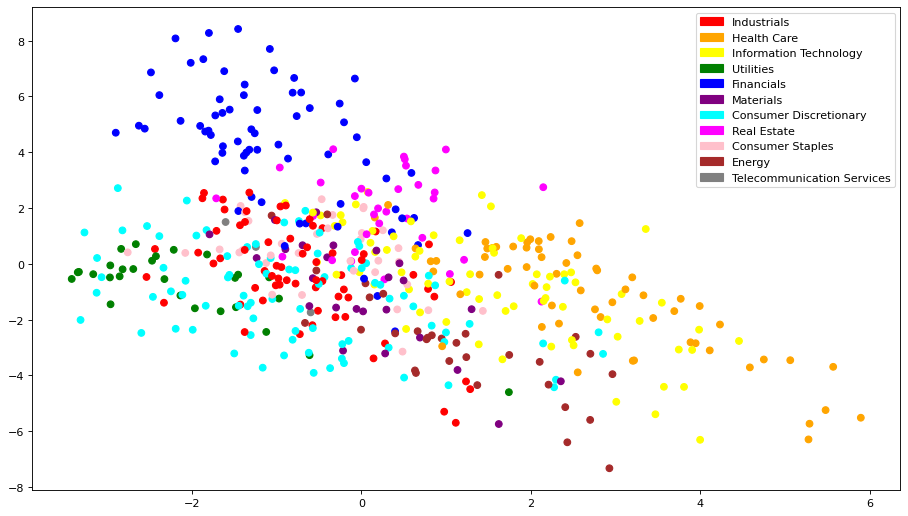

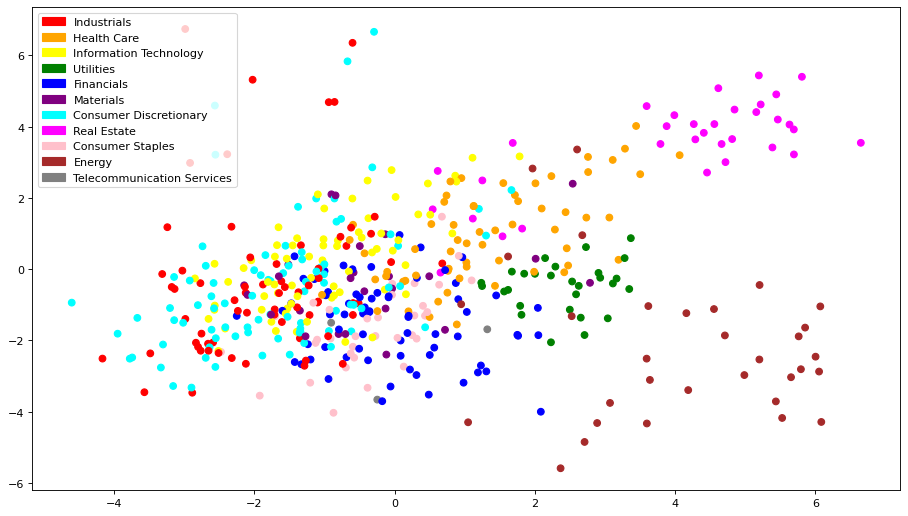

In [35]:
array1X = []
array1Y = []
array2X = []
array2Y = []

# color code by sector
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in words]

# legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')

# graph dimensions 1 & 2
for d in range(0,505):
    array1X.append((model.wv.vectors)[d,0])
    array1Y.append((model.wv.vectors)[d,1])
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(array1X[:], array1Y[:], c=cvec)
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

# graph dimensions 3 & 4
for f in range(0,505):
    array2X.append((model.wv.vectors)[f,2])
    array2Y.append((model.wv.vectors)[f,3])
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(array2X[:], array2Y[:], c=cvec)
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

# Plot 2D Representation

In [36]:
# fit a 2D PCA model to the vectors
X = model.wv.vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
# read stock names from an input file (format: %AAL%)
with open('stocks_data//stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        #if newWordToken in contents:
        newWords.append(words[i])
        newResultX.append(result[i,0])
        newResultY.append(result[i,1])

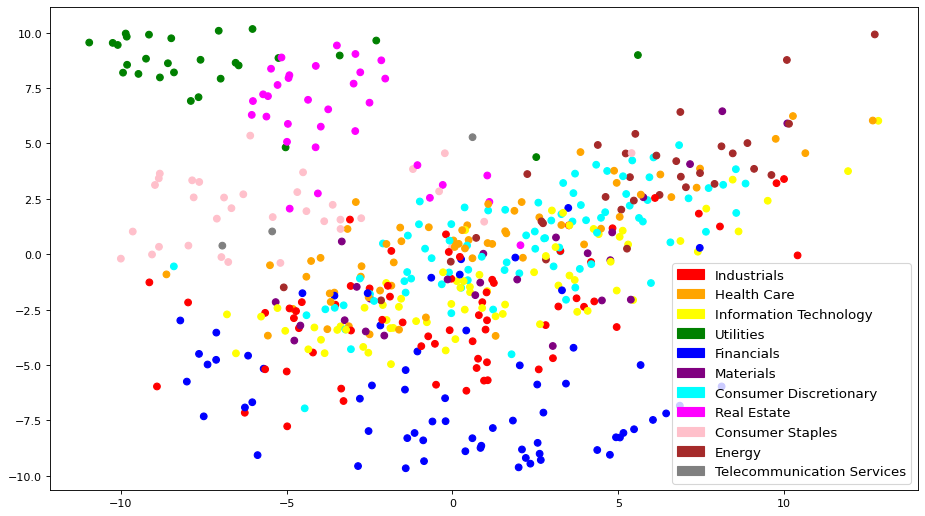

Matrix W;
 [[ 0.1762171  -0.31221277]
 [ 0.06525214 -0.3433411 ]]


In [40]:
#increase size of figure
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

# color code by sector
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]

# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)

# labels(company symbol)
'''
for i, word in enumerate(newWords):
	#pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
    #pyplot.annotate(word, xy=(newResultX[i], newResultY[i]))
'''

pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best', fontsize=12)
pyplot.savefig('PCA.jpg',bbox_inches='tight', dpi=250)
pyplot.show()

# display eigen pairs(coordinate points)
# print(result)
pca.fit(X)
eigen_vals = pca.explained_variance_
eigen_vecs = pca.components_
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:,np.newaxis],eigen_pairs[1][1][:,np.newaxis]))
print('Matrix W;\n',w)

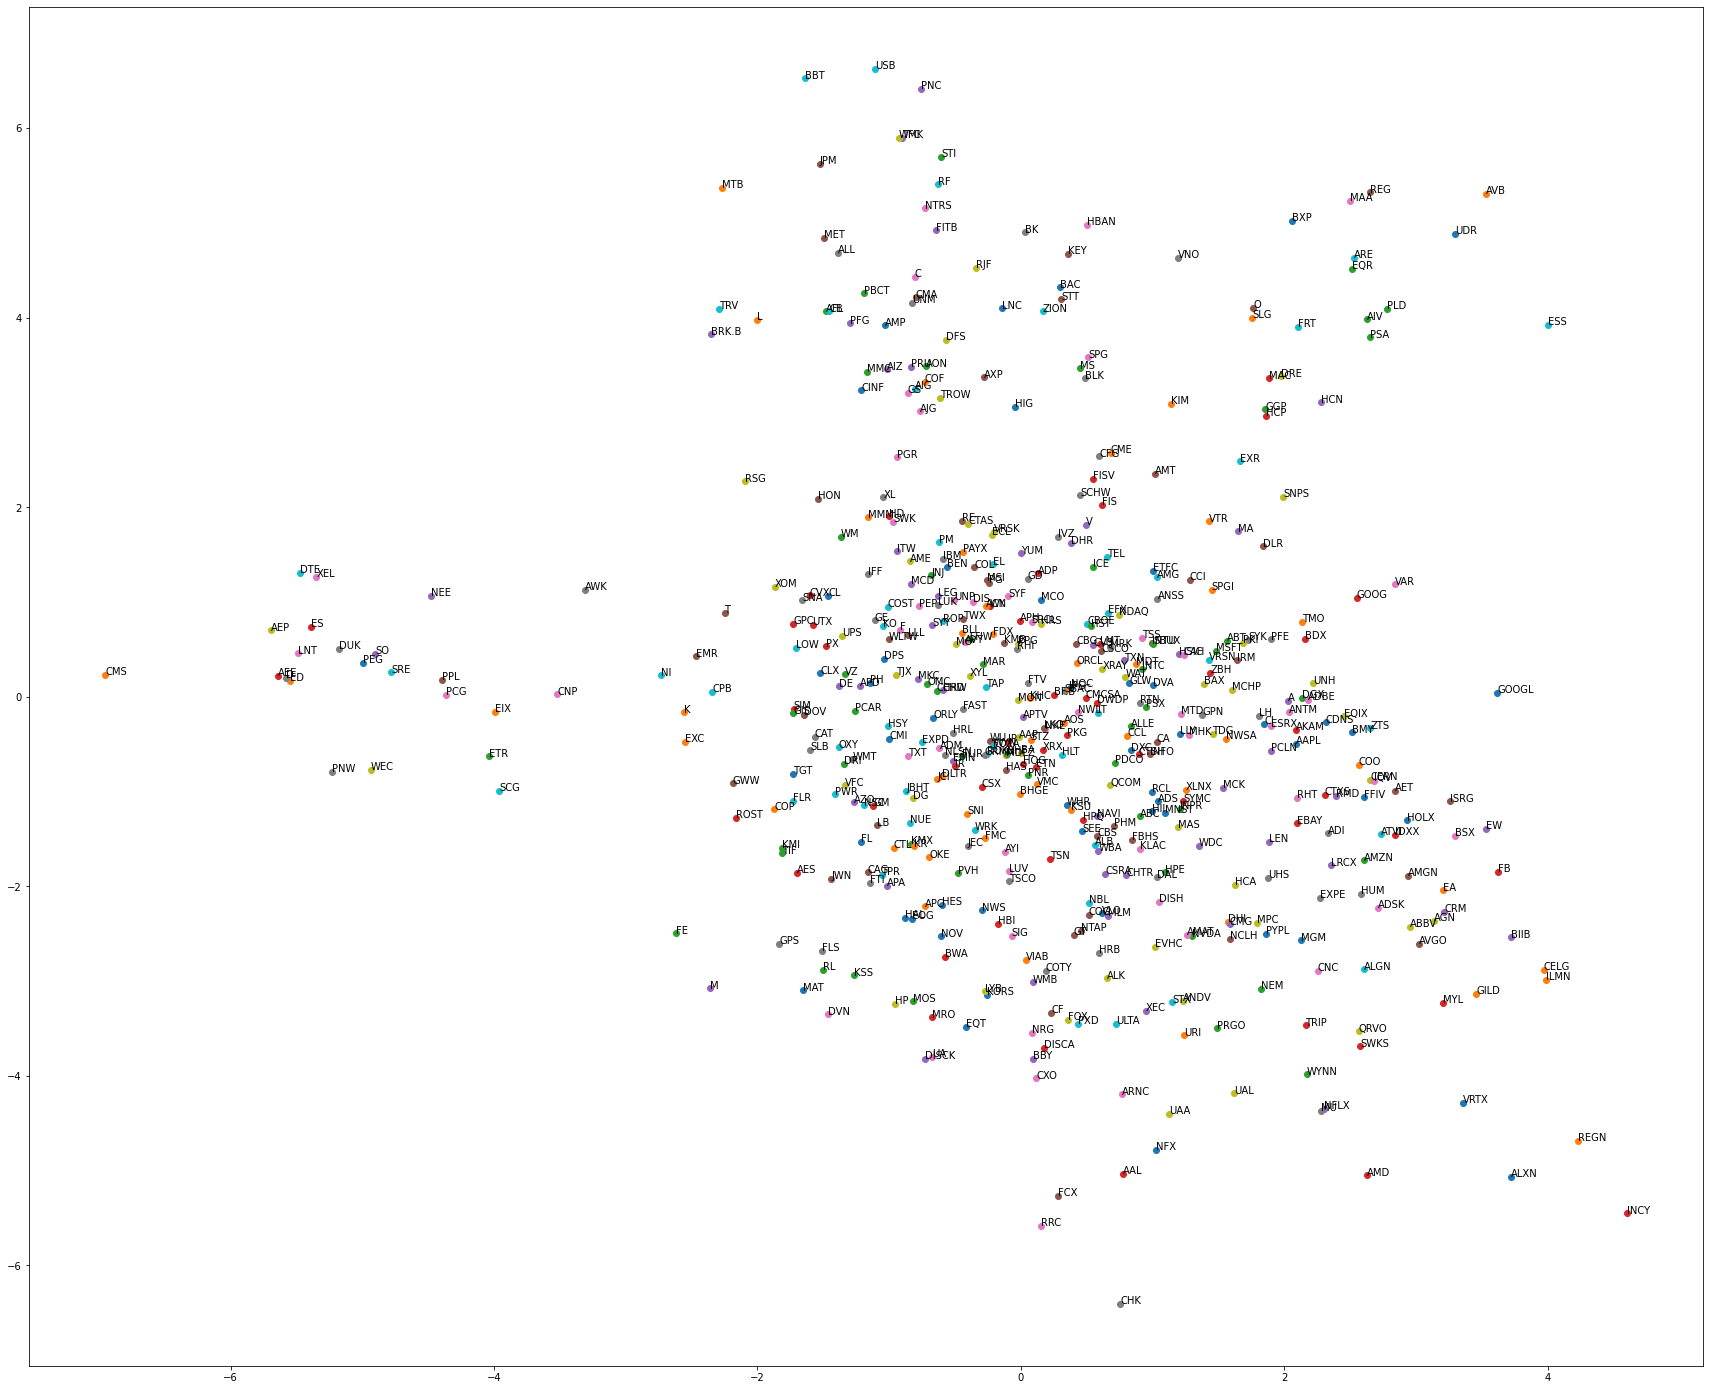

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 25))
# plt.axes(projection='3d')
for word in words:
    coord = model.wv[word]
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))

In [43]:
len(X[:, 0])

505

In [40]:
X.shape

(505, 4)